<a href="https://colab.research.google.com/github/kiyong21c/nadocoding/blob/master/20220207_cv2_matplotlib_KNN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


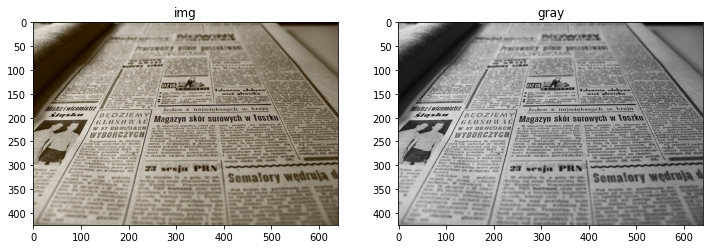

In [ ]:
from google.colab.patches import cv2_imshow # cv2.imshow()는 코랩에서 작동 안함
import cv2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/newspaper.jpg') # cv2는 BGR로 이미지 읽음
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # matplotlib는 RGB로 이미지를 읽기 때문에 변경
gray = cv2.imread('/content/drive/MyDrive/Colab Notebooks/newspaper.jpg', cv2.IMREAD_GRAYSCALE)

# cv2_imshow(img)
# cv2_imshow(gray)

dic = {'img':img, 'gray':gray}
plt.figure(figsize = (12, 12))
for idx, (key, val) in enumerate(dic.items()):
  plt.subplot(1, 2, idx+1)
  plt.title(key)
  plt.imshow(val, cmap='gray')
  # plt.axis('off')

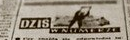

(40, 130, 3)


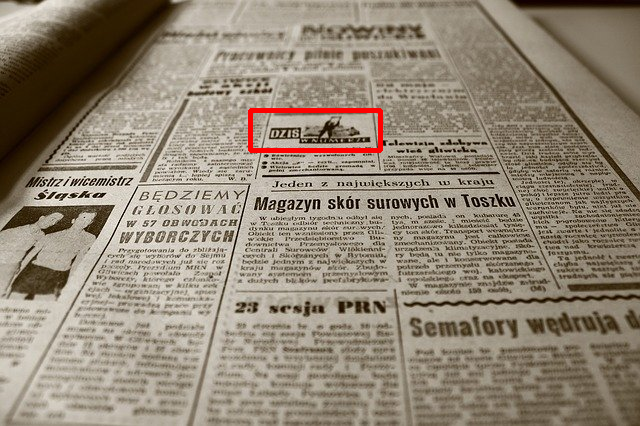

In [ ]:
from google.colab.patches import cv2_imshow # cv2.imshow()는 코랩에서 작동 안함
import cv2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/newspaper.jpg')

COLOR = (0, 0, 255)
THICK = 3

crop = img[110:150, 250:380]
cv2_imshow(crop)
print(crop.shape)
height = crop.shape[0]
width = crop.shape[1]

rec = cv2.rectangle(img, (250, 110), (250+width, 110+height), COLOR, THICK)
cv2_imshow(rec)

# KNN 활용 숫자인식
- 참고사이트 : http://www.gisdeveloper.co.kr/?p=6999

In [7]:
from google.colab.patches import cv2_imshow # cv2.imshow()는 코랩에서 작동 안함
import cv2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/digits.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_resize = cv2.resize(gray, (2000, 1000))

cells = [np.hsplit(row, 100) for row in np.vsplit(gray_resize, 50)] # [[0, ..., 99], [2row], [3row], ..., [50row]]

img = np.array(cells) # 리스트 -> 2차월 배열(array) : [[], [], [], ..., []]


# img.shape # (50, 100, 20, 20) : 50 X 100 배열, 배열의 각 요소는 20 X 20
# img.size # 2,000,000 : 50 X 100 X (20 X 20)
# img[0, 0] # 배열의 첫번째 요소(좌상단)도 역시 20X20의 2차월 배열[[0, ..., 19], [2row], [3row], ..., [20row]]

train = img[:,:50] # 50X100 X(20X20) 크기의 이미지를 가로 앞쪽 50크기로 가져옴
train.shape # (50, 50, 20, 20)
# 이러한 배열은 cv2_imshow() 불가, 2 or 3차원 배열이 아니기 때문

# train.reshape(-1, 20).shape # (50000, 20) 
# cv2_imshow(train.reshape(-1, 20)) # 글자하나의 가로폭크기로 전부 세로로 배치
# reshape(세로:유동적, 가로:20) 후 cv2_imshow() 가능 # 참고사이트 : https://rfriend.tistory.com/345

# 왜 가로(d)를 400크기? : tran/test의 shape이 (N, d) 일때, train_labels가 (N, 1) # 참고사이트 : https://deep-learning-study.tistory.com/286
# 따라서, N값을 맞출것을 고려하여 d값 선정
# 총 5000/2의 글자들 중 글자하나(20X20)를 (1X400)으로 길게 늘어뜨리고, 이에 맞는 세로(N)를 유동적(-1)으로 갖게함(N=2500)
train = train.reshape(-1, 400).astype(np.float32) # shape (N=2500, d=400)
test = img[:, 50:].reshape(-1, 400).astype(np.float32)


# 0 부터 9까지 라벨링 / train, test 라벨 생성
k = np.arange(10)
train_labels = np.repeat(k,250) # array([0, 0, 0, ..., 9, 9, 9]) : k의 각요소를 250번씩 반복
# 왜 250번이냐? : train/test를 나눴기 때문에 각 숫자당 250번씩만 씀
# 따라서, 0-9까지 10개의 숫자를 250번씩 할당하므로 N=2500 -> (2500, 1)
# 따라서, train/test의 shape도 (N, d)로 맞추어야 KNN 알고리즘의 knn.train() 적용가능

train_labels = train_labels[:, np.newaxis] # shape (N=2500, d=1)
test_labels = train_labels.copy()

# KNN 알고리즘 객체 생성
knn = cv2.ml.KNearest_create()
# KNN 알고리즘 학습
knn.train(train, cv2.ml.ROW_SAMPLE, train_labels)
# (2500, 400), layout: 학습 데이터 배치 방법, (2500, 1)
ret, result, neighbors, dist = knn.findNearest(test, k=5)

result # shape (2500, 1), # size 2500
# k값으로 이웃값을 찾은 결과 배열

matches = result == test_labels # 일치하면 True
correct = np.count_nonzero(matches) # 2294 : nonzero를 카운트 = True를 카운트

accuracy = correct*100.0/result.size
print(accuracy) # 91.76 : 인식 성공율

np.savez('knn_data.npz',train=train, train_labels=train_labels) # savez() : 여러배열을 저장, .npz 배열 저장 확장자

with np.load('knn_data.npz') as data: # with로 열면 .close() 필요없음
    print(data.files) # ['train', 'train_labels']
    train = data['train']
    train_labels = data['train_labels']


91.76
['train', 'train_labels']


# KNN 전처리 개념

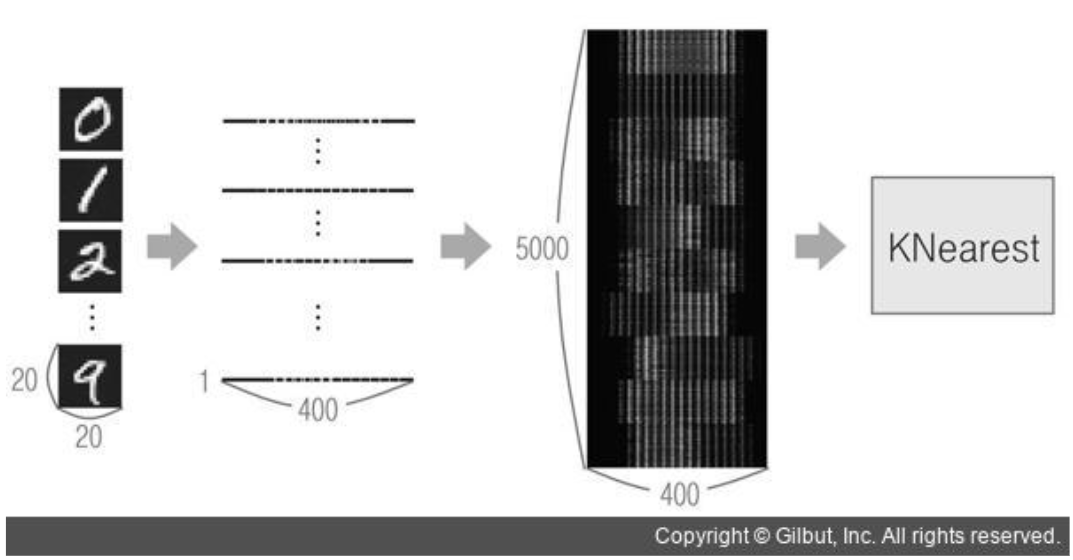

In [4]:
from google.colab.patches import cv2_imshow # cv2.imshow()는 코랩에서 작동 안함
import cv2

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/digits_Knn.png')
cv2_imshow(img)

# (x좌표, y좌표) - (height, width) 정리
> 1. 좌표 : (x, y)
> 2. shape : (세로(범위), 가로(범위))


### np.newaxis
- 참고사이트 : https://codetorial.net/numpy/functions/numpy_repeat.html

In [ ]:
k = np.arange(10)

# np.newaxis의 개념
print(k) # [0 1 2 3 4 5 6 7 8 9]
print(k.shape) # (10,) : 1차원 배열의 경우 y자리 공란
print(k[:, np.newaxis].shape) # (10, 1) : y자리 공란을 처리하기 위해 np.newaxis로 새로운 축을 만듦

# np.newaxis의 활용
train_labels = np.repeat(k,250)
train_labels # array([0, 0, 0, ..., 9, 9, 9]) : k의 각요소를 250번씩 반복
train_labels[:, np.newaxis].shape # (2500, 1)

[0 1 2 3 4 5 6 7 8 9]
(10,)
(10, 1)


(2500, 1)